In [1]:
%matplotlib inline
from scipy.stats import linregress
from scipy.optimize import curve_fit
import seaborn as sns 
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)
import scipy.io

In [2]:
mat = scipy.io.loadmat('plate_9_OD.mat')

In [3]:
t = mat['tps']/3600.
t = t.reshape(max(t.shape))
y = mat['plate_mat']

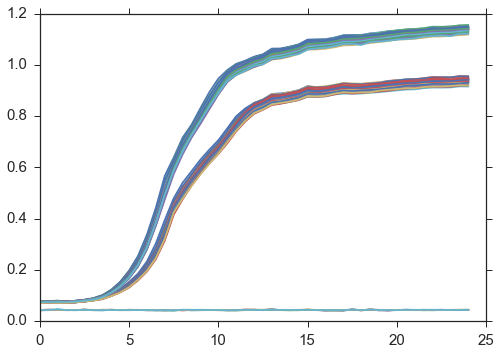

In [4]:
plot(np.transpose(t), np.transpose(y));

In [58]:
#control = mat['populations_OD'][0,0][3][0]
#assay = mat['populations_OD'][0,1][3][0]

## checkerboard
blank = np.arange(12)
assay = np.array([13,15,17,19,21,23,26,28,30,32,34,36,37,39,41,43,45,47,50,52,54,56,58,60,61,63,65,67,69,71,74,76,78,80,82,84,85,87,89,91,93,95])
control = np.array([14,16,18,20,22,24,25,27,29,31,33,35,38,40,42,44,46,48,49,51,53,55,57,59,62,64,66,68,70,72,73,75,77,79,81,83,86,88,90,92,94])

In [59]:
print control
print assay

[14 16 18 20 22 24 25 27 29 31 33 35 38 40 42 44 46 48 49 51 53 55 57 59 62 64
 66 68 70 72 73 75 77 79 81 83 86 88 90 92 94]
[13 15 17 19 21 23 26 28 30 32 34 36 37 39 41 43 45 47 50 52 54 56 58 60 61 63
 65 67 69 71 74 76 78 80 82 84 85 87 89 91 93 95]


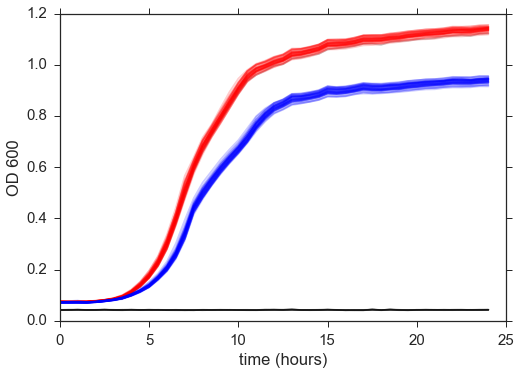

In [60]:
plot(t, np.transpose(y[blank-1]),  color='k', alpha=0.2);
plot(t, np.transpose(y[control-1]),  color='r', alpha=0.2);
plot(t, np.transpose(y[assay-1]), color='b', alpha=0.2)
xlabel('time (hours)')
ylabel('OD 600');

In [13]:
colors = {}
for i in blank: colors[i] = 'k'
for i in control: colors[i] = 'r'
for i in assay: colors[i] = 'b'

blue - assay
green - control
black - blank


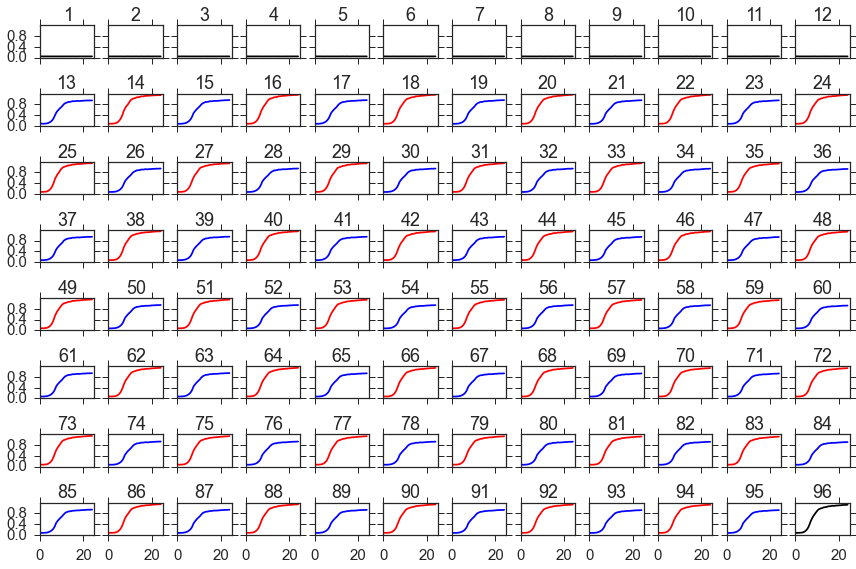

In [14]:
fig, ax = subplots(8,12,sharex=True, sharey=True, figsize=(12,8))
for i in range(8):
    for j in range(12):
        ax[i,j].plot(t, np.transpose(y[12*i + j]), colors.get(12*i + j+1, 'k'))
        ax[i,j].set_title(str(12*i+j+1))
ax[0,0].set_xticks([0,20])
ax[0,0].set_yticks([0,0.4,0.8])
fig.tight_layout()
print 'blue - assay\ngreen - control\nblack - blank'

## Logistic estimation

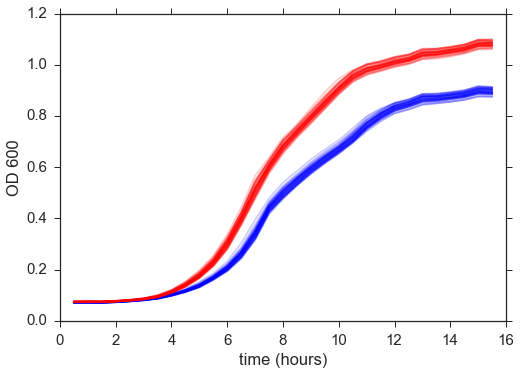

In [15]:
start = 0
stop_assay = 16
stop_control = 16
t_assay = t[(start<t) & (t<stop_assay)]
y_assay = np.transpose(y[assay-1])[(start<t) & (t<stop_assay)]
plot(t_assay, y_assay, 'b', alpha=0.2);
y_control = np.transpose(y[control-1])[(start<t) & (t<stop_control)]
t_control = t[(start<t) & (t<stop_control)]
plot(t_control, y_control, 'r', alpha=0.2)
xlabel('time (hours)')
ylabel('OD 600');

In [16]:
def trans(x):
    return np.log(x[1:]/x[:-1])

1.14873727275 1.15552549995
assay: lam 1.14873727275 K 1.15552549995
control: lam 1.1762268109 K 1.28342320024
s 0.0236483818805


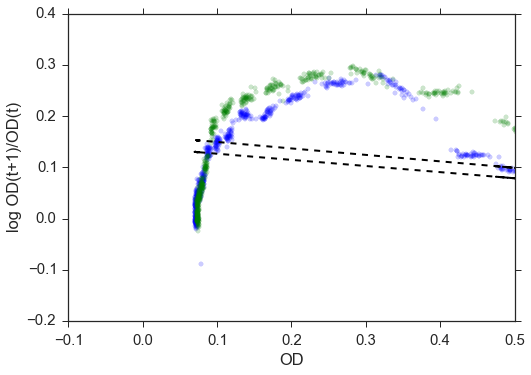

In [17]:
scatter(y_assay[:-1,:].flatten(), trans(y_assay).flatten(), color='b', alpha=0.2)
a, b, rval, _, _ = linregress(y_assay[:-1,:].flatten(), trans(y_assay).flatten())
plot(y_assay[:-1,:].flatten(), b+a*y_assay[:-1,:].flatten(), 'k--', lw=2)
xlim(-0.1,0.5)
xlabel('OD')
ylabel('log OD(t+1)/OD(t)')
lam_assay = np.exp(b)
K_assay = -b/a
print lam_assay,K_assay
print "assay: lam",lam_assay,"K",K_assay

scatter(y_control[:-1,:].flatten(), trans(y_control).flatten(), color='g', alpha=0.2)
a, b, rval, _, _ = linregress(y_control[:-1,:].flatten(), trans(y_control).flatten())
plot(y_control[:-1,:].flatten(), b+a*y_control[:-1,:].flatten(), 'k--', lw=2)
xlim(-0.1,0.5)
xlabel('OD')
ylabel('log OD(t+1)/OD(t)')
lam_control = np.exp(b)
K_control = -b/a
print "control: lam", lam_control,"K",K_control
print "s", np.log(lam_control/lam_assay)

## Logistic fitting

$$
\frac{dN}{dt} = r N (1-N/K) \\
N(t) = \frac{K N_0 e^{rt}}{K + N_0 (e^{rt}-1)}
$$

In [18]:
def logistic(t, *p):
    r, K, N0 = p
    return K * N0 * np.exp(r * t) / (K + N0 * (np.exp(r * t) - 1))

In [19]:
(r_control,K_control,N0_control), pcov = curve_fit(logistic, np.repeat(t_control, y_control.shape[1]), y_control.flatten(), p0=(1,1,0))
perr = np.sqrt(np.diag(pcov))
print 'r',r_control,'K',K_control,'N0',N0_control
print 'errors',perr

r 0.630237419406 K 1.07456209852 N0 0.0108526483819
errors [ 0.004  0.002  0.   ]


In [20]:
(r_assay,K_assay,N0_assay), pcov = curve_fit(logistic, np.repeat(t_assay, y_assay.shape[1]), y_assay.flatten(), p0=(1,1,0))
perr = np.sqrt(np.diag(pcov))
print 'r',r_assay,'K',K_assay,'N0',N0_assay
print 'errors',perr

r 0.527696185302 K 0.918866166415 N0 0.0137791296569
errors [ 0.004  0.002  0.   ]


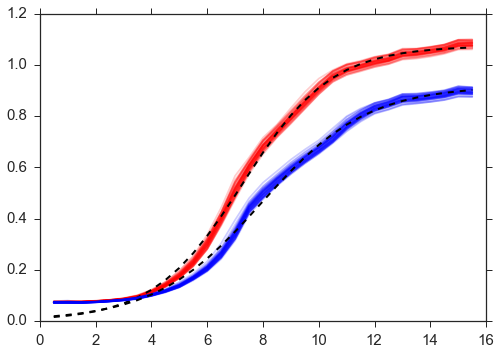

In [21]:
plot(t_control,  y_control, 'r', alpha=0.2)
plot(t_control, logistic(t_control, r_control, K_control, N0_control), 'k--', lw=2);
plot(t_assay,  y_assay, 'b', alpha=0.2)
plot(t_assay, logistic(t_assay, r_assay, K_assay, N0_assay), 'k--', lw=2);

## Logistic fit with diauxic phase

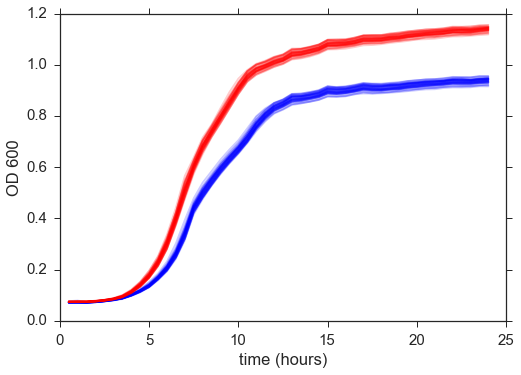

In [22]:
start = 0
stop_assay = 100
stop_control = 100
t_assay = t[(start<t) & (t<stop_assay)]
y_assay = np.transpose(y[assay-1])[(start<t) & (t<stop_assay)]
plot(t_assay, y_assay, 'b', alpha=0.2);
y_control = np.transpose(y[control-1])[(start<t) & (t<stop_control)]
t_control = t[(start<t) & (t<stop_control)]
plot(t_control, y_control, 'r', alpha=0.2)
xlabel('time (hours)')
ylabel('OD 600');

$$
N(t) = 1_{t \le T} \cdot \frac{K N_0 e^{r_1 t}}{K + N_0 (e^{r_1 t}-1)} + 1_{t \ge T} \cdot N(T) + e^{r_2 (t-T)}
$$

In [23]:
def logistic_diauxic(t, *p):
    r1, r2, K, N0, T, NT = p
    return (t<T) * K * N0 * np.exp(r1 * t) / (K + N0 * (np.exp(r1 * t) - 1)) + (t>=T) * K * NT * np.exp(r2 * t) / (K + NT * (np.exp(r2 * t) - 1))

In [24]:
(r1_c, r2_c, K_c, N0_c, T_c, NT_c), pcov = curve_fit(logistic_diauxic, np.repeat(t_control, y_control.shape[1]), y_control.flatten(), 
                                                     p0=[(1,0.1,1,0,10,0.5)])
perr = np.sqrt(np.diag(pcov))
print 'r1',r1_c,'r2',r2_c,'K',K_c,'N0',N0_c,'T',T_c,'NT',NT_c
print 'errors',perr

r1 0.591658996332 r2 0.241132290937 K 1.14143823514 N0 0.0132249489346 T 10.0000000093 NT 0.341750712691
errors [ inf  inf  inf  inf  inf  inf]


C:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [25]:
(r1_a, r2_a, K_a, N0_a, T_a, NT_a), pcov = curve_fit(logistic_diauxic, np.repeat(t_assay, y_assay.shape[1]), y_assay.flatten(), 
                                                     p0=[(1,0.1,K_c,N0_c,12.5,0.5)])
perr = np.sqrt(np.diag(pcov))
print 'r1',r1_a,'r2',r2_a,'K',K_a,'N0',N0_a,'T',T_a,'NT',NT_a
print 'errors',perr

r1 0.508935459072 r2 0.219964996304 K 0.94340343815 N0 0.0153303025767 T 12.5 NT 0.359042966553
errors [ inf  inf  inf  inf  inf  inf]


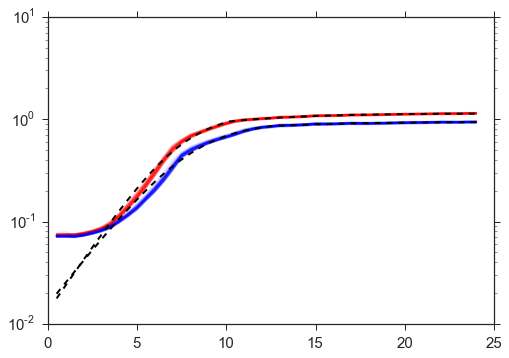

In [26]:
plot(t_control,  y_control, 'r', alpha=0.1)
plot(t_assay,  y_assay, 'b', alpha=0.1)
yscale('log')

t_ = np.linspace(t_control.min(),t_control.max())
plot(t_, [logistic_diauxic(t__, r1_c, r2_c, K_c, N0_c, T_c, NT_c) for t__ in t_], 'k--', lw=2);
t_ = np.linspace(t_assay.min(),t_assay.max())
plot(t_, [logistic_diauxic(t__, r1_a, r2_a, K_a, N0_a, T_a, NT_a) for t__ in t_], 'k--', lw=2);

In [27]:
print "s1 =", np.log(2) * (r1_c-r1_a)/r1_a
print "s2 =", np.log(2) * (r2_c-r2_a)/r2_a

s1 = 0.112665733142
s2 = 0.0667017518281


## Fitting modified Gompertz

$$
N(t) = A \cdot \exp{[-\exp{(1 + (\lambda-t) \frac{\mu \cdot e}{A})}]} 
+ A\cdot \exp{(\alpha(t-t_{shift}))}
$$

In [28]:
def mod_gomp(t, *p):
    A,mu,lam,alpha,tshift = p
    return A * np.exp(-np.exp(1 + (lam - t) * mu*np.e/A)) + A * np.exp(alpha * (t-tshift))

In [29]:
(A_c,mu_c,lam_c,alpha_c,tshift_c), pcov = curve_fit(mod_gomp, np.repeat(t_control, y_control.shape[1]), y_control.flatten(), 
                                                     p0=[(1,0.1,1,0.1,10)])
perr = np.sqrt(np.diag(pcov))
print 'A',A_c,'mu',mu_c,'lam',lam_c,'alpha',alpha_c,'shift',tshift_c
print 'errors',perr

A 0.953685556497 mu 0.183259691356 lam 4.80297886498 alpha 0.0391144627704 shift 65.0849931873
errors [  1.811e-03   5.358e-04   9.856e-03   5.354e-04   8.736e-01]


In [30]:
(A_a,mu_a,lam_a,alpha_a,tshift_a), pcov = curve_fit(mod_gomp, np.repeat(t_assay, y_assay.shape[1]), y_assay.flatten(), 
                                                     p0=[(1,0.1,1,0.1,10)])
perr = np.sqrt(np.diag(pcov))
print 'A',A_a,'mu',mu_a,'lam',lam_a,'alpha',alpha_a,'shift',tshift_a
print 'errors',perr

A 0.818463914226 mu 0.134151054147 lam 5.06420161355 alpha 0.0192884614188 shift 124.14624352
errors [  2.963e-03   4.710e-04   1.510e-02   1.326e-03   8.604e+00]


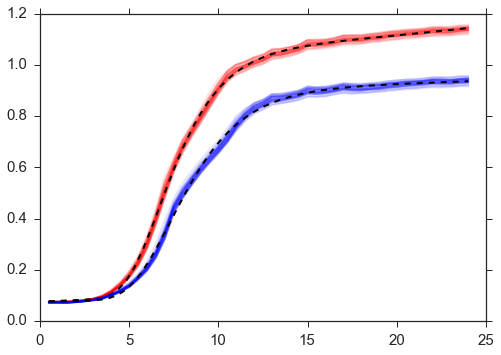

In [31]:
plot(t_control,  y_control, 'r', alpha=0.1)
t_ = np.linspace(t_control.min(),t_control.max())
plot(t_, [mod_gomp(t__, A_c,mu_c,lam_c,alpha_c,tshift_c) for t__ in t_], 'k--', lw=2);

plot(t_assay,  y_assay, 'b', alpha=0.1)
t_ = np.linspace(t_assay.min(),t_assay.max())
plot(t_, [mod_gomp(t__, A_a,mu_a,lam_a,alpha_a,tshift_a) for t__ in t_], 'k--', lw=2);

## Fitting logistic with lag phase

$$
N(t) = \frac{A}{1 + \exp(2 + (\lambda - t)\frac{4\mu}{A})}
$$

In [32]:
def logistic2(t, *p):
    A, mu, lam = p
    return A / (1 + np.exp(2 + (lam - t) * 4 * mu / A))

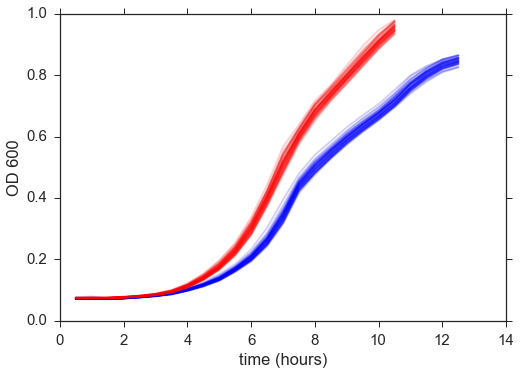

In [33]:
start = 0
stop_assay = 13
stop_control = 11
t_assay = t[(start<t) & (t<stop_assay)]
y_assay = np.transpose(y[assay-1])[(start<t) & (t<stop_assay)]
plot(t_assay, y_assay, 'b', alpha=0.2);
y_control = np.transpose(y[control-1])[(start<t) & (t<stop_control)]
t_control = t[(start<t) & (t<stop_control)]
plot(t_control, y_control, 'r', alpha=0.2)
xlabel('time (hours)')
ylabel('OD 600');

In [34]:
(A_c,mu_c,lam_c), pcov = curve_fit(logistic2, np.repeat(t_control, y_control.shape[1]), y_control.flatten(), 
                                                     p0=[(1,0,0)])
perr = np.sqrt(np.diag(pcov))
print 'A',A_c,'mu',mu_c,'lam',lam_c
print 'errors',perr

A 1.08600203713 mu 0.169909916494 lam 4.11810426586
errors [ 0.008  0.001  0.021]


In [35]:
(A_a,mu_a,lam_a), pcov = curve_fit(logistic2, np.repeat(t_assay, y_assay.shape[1]), y_assay.flatten(), 
                                                     p0=[(1,0,0)])
perr = np.sqrt(np.diag(pcov))
print 'A',A_a,'mu',mu_a,'lam',lam_a
print 'errors',perr

A 0.934187303889 mu 0.120342948505 lam 4.13255347254
errors [ 0.005  0.001  0.023]


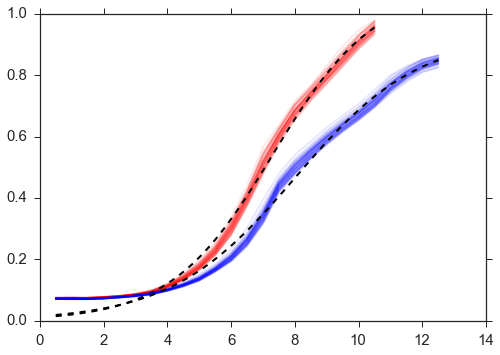

In [36]:
plot(t_control,  y_control, 'r', alpha=0.1)
t_ = np.linspace(t_control.min(),t_control.max())
plot(t_, [logistic2(t__, A_c,mu_c,lam_c) for t__ in t_], 'k--', lw=2);

plot(t_assay,  y_assay, 'b', alpha=0.1)
t_ = np.linspace(t_assay.min(),t_assay.max())
plot(t_, [logistic2(t__, A_a,mu_a,lam_a) for t__ in t_], 'k--', lw=2);

## Richards

$$
\frac{dN}{dt} = r N (1-(N/A)^\nu) \\
N(t) = A \cdot [ 1 + \nu \cdot exp(1 + \nu + \frac{\mu}{A} \cdot (1+\nu)^{1+1/\nu} \cdot (\lambda-t))]^{-1/\nu}
$$


In [37]:
def richards(t, *p):
    A,mu,lam,nu = p
    return A * (1. + nu * np.exp(1. + nu + (mu/A) * ((1. + nu)**(1. + 1./nu)) * (lam - t)))**(-1./nu)

In [44]:
(A_c,mu_c,lam_c,nu_c), pcov = curve_fit(richards, np.repeat(t_control, y_control.shape[1]), y_control.flatten(), 
                                                     p0=[(1,0.1,0,1)])
perr = np.sqrt(np.diag(pcov))
print 'A',A_c,'mu',mu_c,'lam',lam_c,'nu',nu_c
print 'errors',perr

A 0.969598005633 mu 0.187802625204 lam 4.43728750786 nu 2.25815658234
errors [ 0.007  0.002  0.036  0.134]


In [45]:
(A_a,mu_a,lam_a,nu_a), pcov = curve_fit(richards, np.repeat(t_assay, y_assay.shape[1]), y_assay.flatten(), 
                                                     p0=[(1,0.1,0,0.1)])
perr = np.sqrt(np.diag(pcov))
print 'A',A_a,'mu',mu_a,'lam',lam_a,'nu',nu_a
print 'errors',perr

A 0.87148146851 mu 0.128390655653 lam 4.40104087838 nu 1.79513927106
errors [ 0.006  0.001  0.041  0.103]


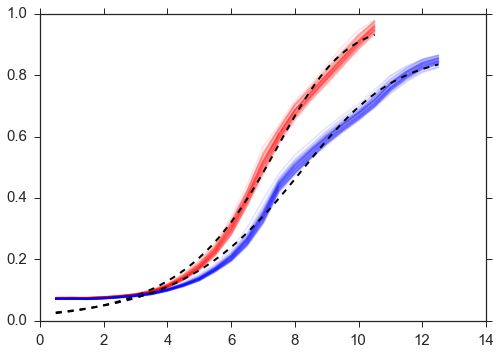

In [46]:
plot(t_control,  y_control, 'r', alpha=0.1)
t_ = np.linspace(t_control.min(),t_control.max())
plot(t_, [richards(t__, A_c,mu_c,lam_c,nu_c) for t__ in t_], 'k--', lw=2);

plot(t_assay,  y_assay, 'b', alpha=0.1)
t_ = np.linspace(t_assay.min(),t_assay.max())
plot(t_, [richards(t__, A_a,mu_a,lam_a,nu_a) for t__ in t_], 'k--', lw=2);


## Baranyi-Roberts

$$
\frac{dN}{dt} = r \alpha(t) N (1 - (N/K)^\nu) \\
A(t) = t + \frac{1}{\nu} \log{\Big( \frac{e^{-\nu t} + q0}{1 + q0} \Big)} \\
N(t) = \frac{K}{\Big( 1 + \Big( \Big(\frac{K}{N_0}\Big)^{\nu} - 1 \Big) e^{-r \nu A(t)} \Big)^{1/\nu}} \\
$$

In [47]:
def baranyi_roberts(t, K, y0, r, nu, q0, v):
    A = t + (1./v) * np.log((np.exp(-v*t) + q0)/(1 + q0))
    return K/(1 + (-1 + (K/y0)**nu) * np.exp(-r * nu * A))**(1./nu)

In [48]:
from lmfit import Model
def bic(model_fit):
    n = model_fit.ndata
    k = model_fit.nvarys    
    rss = np.float((model_fit.residual**2).sum())
    return n * np.log(rss / n) + np.log(n) * k

In [53]:
def fit_baranyi_roberts(t, y, well=None, ax=None, PLOT=True):
    models = []
    baranyi_roberts_model = Model(baranyi_roberts)
    params = baranyi_roberts_model.make_params(y0=y.min(), K=y.max(), r=1.0, nu=1.0, q0=0, v=1.0)
    params['y0'].set(min=1-10)
    params['K'].set(min=1-10)
    params['r'].set(min=1-10)
    params['nu'].set(min=1-10)
    params['q0'].set(min=1e-10, max=1)
    params['v'].set(min=1e-10)
    
    # full model
    result = baranyi_roberts_model.fit(y, t=t, params=params)
    models.append(result)
    
    # fix y0 and K to empirical data
    params['y0'].set(vary=False)
    params['K'].set(vary=False)
    result = baranyi_roberts_model.fit(data=y, t=t, params=params)
    models.append(result)
    
    # no lag
    params['q0'].set(value=1.0, vary=False)
    params['v'].set(vary=False)
    result = baranyi_roberts_model.fit(data=y, t=t, params=params)
    models.append(result)
    
    # logistic
    params['nu'].set(vary=False)
    result = baranyi_roberts_model.fit(data=y, t=t, params=params)
    models.append(result)
    
    # sort by increasing aic/bic
    models.sort(key=bic)

    # plot
    if PLOT:
        dy = y.max()/50
        dx = t.max()/25
        fig, ax = subplots(1, len(models), sharex=True, sharey=True, figsize=(16,6))
        for i,fit in enumerate(models):
            vals = fit.best_values
            fit.plot_fit(ax=ax[i], datafmt='.', fit_kws={'lw':4})
            ax[i].axhline(y=vals['y0'], color='k', ls='--')
            ax[i].text(x=t.max() + dx, y=vals['y0'] + dy, s='y0')
            ax[i].axhline(y=vals['K'], color='k', ls='--')
            ax[i].text(x=t.max() + dx, y=vals['K'] + dy, s='K')
            lam = np.log(1. + 1./vals['q0']) / vals['v']        
            ax[i].axvline(x=lam, color='k', ls='--')
            ax[i].text(x=lam + dx, y=y.min() - 3*dy, s=r'$\lambda$')
            ax[i].set_title('Model: %s params, BIC: %d' % (fit.nvarys, bic(fit)))
            ax[i].get_legend().set_visible(False)            
            ax[i].set_xlim(0, 1.1 * t.max())
            ax[i].set_ylim(0, 1.1 * y.max())
            ax[i].set_xlabel('Time')
            ax[i].set_ylabel('')
        ax[0].set_ylabel('OD')
        sns.despine()
    return models, ax

In [63]:
control,assay = assay,control # TODO check this

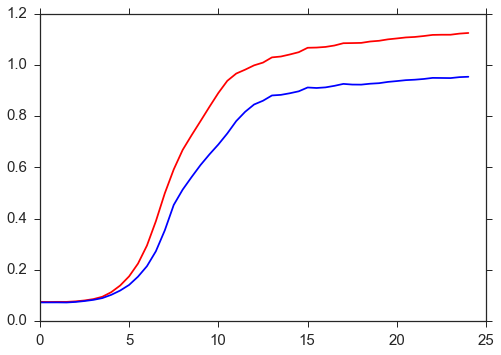

In [64]:
plot(t,y[control].mean(axis=0),'r')
plot(t,y[assay].mean(axis=0),'b')

[[Model]]
    Model(baranyi_roberts)
[[Fit Statistics]]
    # function evals   = 2492
    # data points      = 49
    # variables        = 6
    chi-square         = 0.007
    reduced chi-square = 0.000
[[Variables]]
    q0:   0.00045550 +/- 0.000946 (207.73%) (init= 1e-10)
    K:    1.10301131 +/- 0.003066 (0.28%) (init= 1.125395)
    r:    386.212021 +/- 1.29e+05 (33511.33%) (init= 1)
    v:    1.79436228 +/- 0.588052 (32.77%) (init= 1)
    y0:   0.07702704 +/- 0.005090 (6.61%) (init= 0.07367857)
    nu:   0.00112960 +/- 0.378716 (33526.35%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(r, nu)                     = -1.000 
    C(q0, v)                     = -0.976 
    C(r, v)                      = -0.709 
    C(v, nu)                     =  0.709 
    C(q0, y0)                    = -0.558 
    C(q0, r)                     =  0.549 
    C(q0, nu)                    = -0.549 
    C(v, y0)                     =  0.480 
    C(r, y0)                     = -0.18

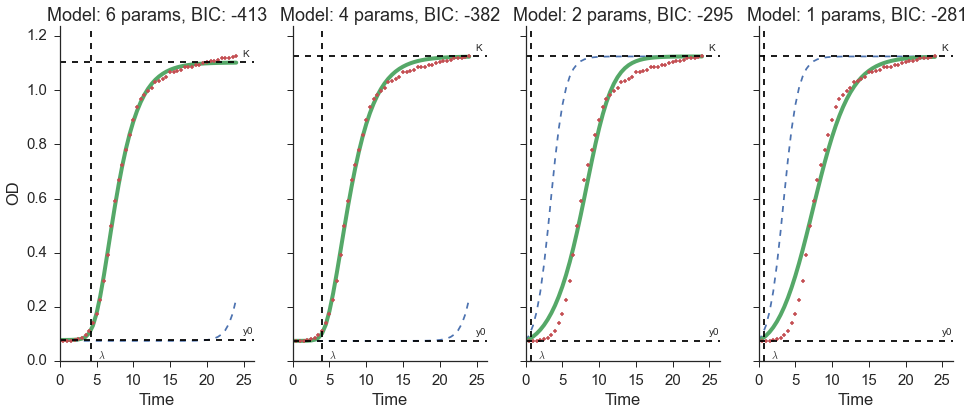

In [65]:
models, ax = fit_baranyi_roberts(t, y[control].mean(axis=0), PLOT=True)
control_fit = models[0]
print control_fit.fit_report()

[[Model]]
    Model(baranyi_roberts)
[[Fit Statistics]]
    # function evals   = 3137
    # data points      = 49
    # variables        = 6
    chi-square         = 0.004
    reduced chi-square = 0.000
[[Variables]]
    q0:   0.00147430 +/- 0.001672 (113.46%) (init= 1e-10)
    K:    0.94387353 +/- 0.002658 (0.28%) (init= 0.9542)
    r:    334.817524 +/- 1.35e+05 (40376.13%) (init= 1)
    v:    1.39100012 +/- 0.342440 (24.62%) (init= 1)
    y0:   0.07444622 +/- 0.004077 (5.48%) (init= 0.07159024)
    nu:   0.00122743 +/- 0.495801 (40393.37%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(r, nu)                     = -1.000 
    C(q0, v)                     = -0.914 
    C(r, v)                      = -0.737 
    C(v, nu)                     =  0.737 
    C(q0, y0)                    = -0.626 
    C(v, y0)                     =  0.508 
    C(q0, r)                     =  0.408 
    C(q0, nu)                    = -0.408 
    C(r, y0)                     = -0.198 

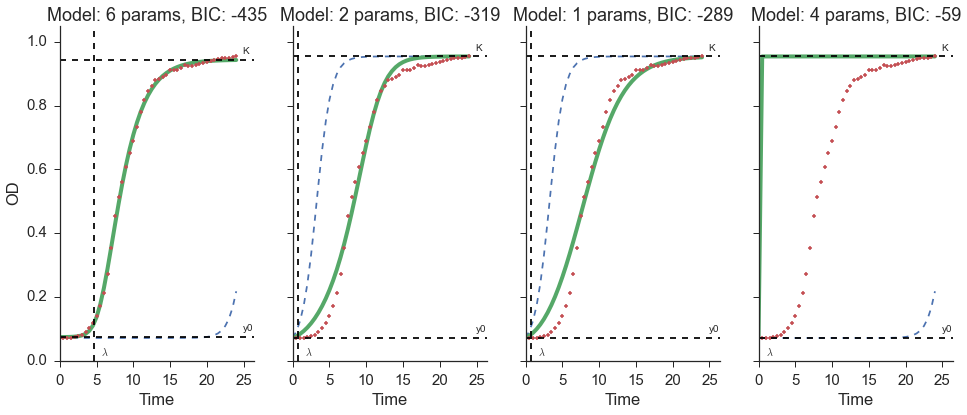

In [66]:
models, ax = fit_baranyi_roberts(t, y[assay].mean(axis=0), PLOT=True)
assay_fit = models[0]
print assay_fit.fit_report()

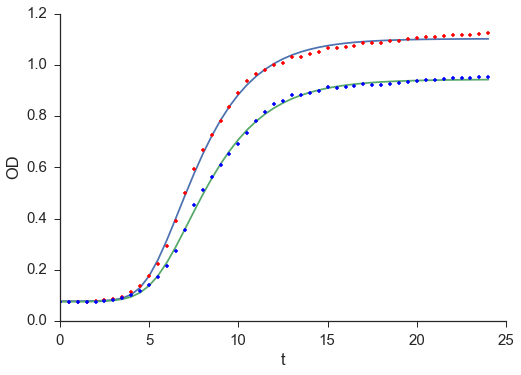

In [70]:
control_fit.plot_fit(data_kws={'marker':'.', 'color':'r'}, init_kws={'marker':'','ls':'', 'color':'r'})
assay_fit.plot_fit(data_kws={'marker':'.', 'color':'b'}, init_kws={'marker':'','ls':'', 'color':'b'})
lg = legend(loc='upper left')
lg.set_visible(False)
ylabel('OD')
sns.despine()
savefig("plate_9_OD_fit.png", dpi=300)

# Competition

$$
\frac{dy_i}{dt} = r_i y_i \alpha_i(t) \Big( 1 - \Big( \frac{\sum_j{y_j}}{K_i} \Big)^{\nu_i} \Big)
$$

In [72]:
import odespy

In [73]:
def get_params(model_fit):
    r = model_fit.best_values['r']
    K = model_fit.best_values['K']
    nu = model_fit.best_values['nu']
    q0 = model_fit.best_values['q0']
    v = model_fit.best_values['v']
    y0 = model_fit.best_values['y0']
    return y0,r,K,nu,q0,v

In [74]:
def alpha(t,q0,v):
    return q0 / (q0 + np.exp(-np.array(v)*t))

def dydt(y, t, r, K, nu, q0, v):
    alfa = alpha(t, q0, v)
    return r * y * alfa * (1 - (y.sum()/K)**nu)

In [75]:
y0_0,r_0,K_0,nu_0,q0_0,v_0 = get_params(control_fit)
y0_1,r_1,K_1,nu_1,q0_1,v_1 = get_params(assay_fit)

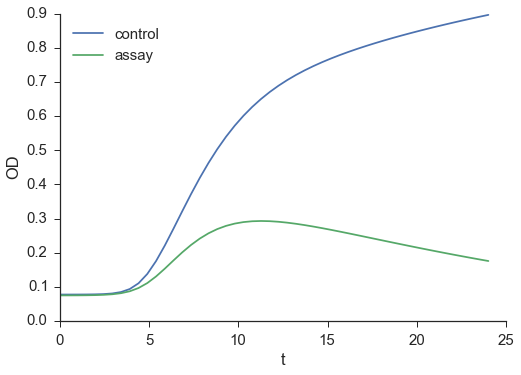

In [83]:
solver = odespy.RungeKutta4(lambda y,t: dydt(y, t, (r_0,r_1), (K_0,K_1), (nu_0,nu_1), (q0_0,q0_1), (v_0,v_1) ))
solver.set_initial_condition((y0_0,y0_1))
t = np.linspace(0, 24)
y,t = solver.solve(t)

plot(t,y)
xlabel('t')
ylabel('OD')
legend(labels=['control','assay'], loc='upper left')
sns.despine();

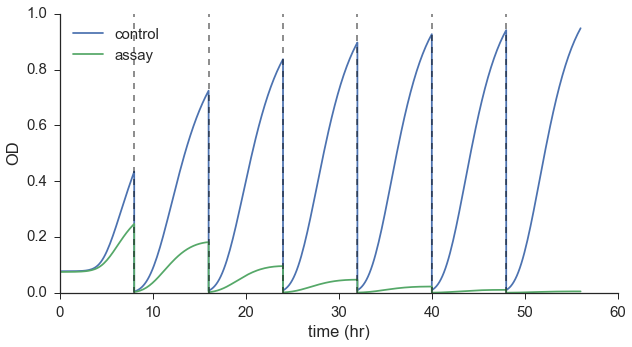

In [86]:
y0_0,r_0,K_0,nu_0,q0_0,v_0 = get_params(control_fit)
y0_1,r_1,K_1,nu_1,q0_1,v_1 = get_params(assay_fit)
t = np.array([0])
y = np.array([[y0_0,y0_1]])
cycle_len = 8
min_y = 1e-4
solver = odespy.RungeKutta4(lambda y,t: dydt(y, t, (r_0,r_1), (K_0,K_1), (nu_0,nu_1), (q0_0,q0_1), (v_0,v_1) ))

while y0_0 > min_y and y0_1 > min_y:
    solver.set_initial_condition((y0_0,y0_1))
    t_ = np.linspace(t.max(), t.max() + cycle_len) # TODO add lag!
    y_,t_ = solver.solve(t_)
    t = np.concatenate((t,t_))
    y = np.concatenate((y,y_))
    y0_0,y0_1 = y[-1,:]/100.

fig, ax = subplots(1,1,figsize=(10,5))
ax.plot(t,y)
ax.set_xlabel('time (hr)')
ax.set_ylabel('OD')
ax.legend(labels=['control','assay'], loc='best') 
sns.despine();
[axvline(x=x, color='k', ls='--', alpha=0.5) for x in np.arange(0, t.max(), cycle_len)];

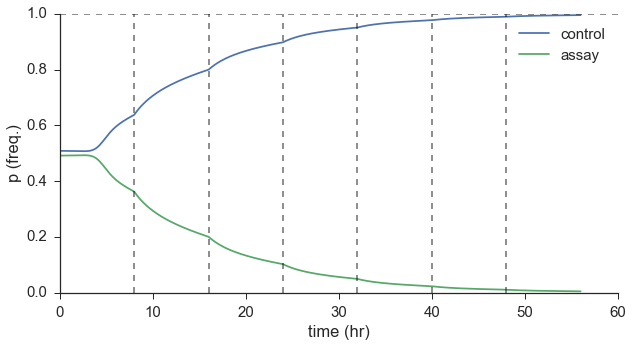

In [87]:
p = np.array([y[:,0]/y.sum(axis=1), y[:,1]/y.sum(axis=1)]).transpose()

fig, ax = subplots(1,1,figsize=(10,5))
ax.plot(t,p)
ax.axhline(y=1, ls='--', color='k', alpha=0.5)
ax.set_xlabel('time (hr)')
ax.set_ylabel('p (freq.)')
ax.legend(labels=['control','assay'], loc='best') 
sns.despine();
[axvline(x=x, color='k', ls='--', alpha=0.5) for x in np.arange(0, t.max(), cycle_len)];

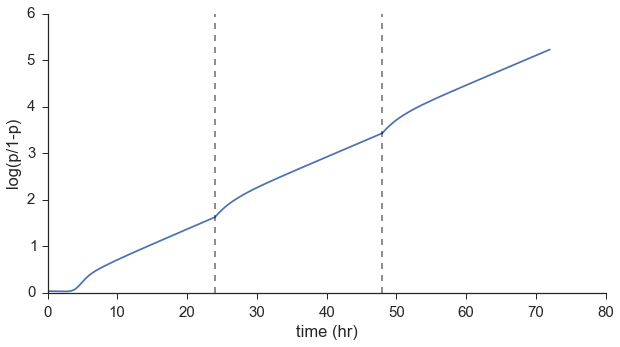

In [360]:
logpp = np.log(p[:,0]/p[:,1])

fig, ax = subplots(1,1,figsize=(10,5))
ax.plot(t,logpp)
ax.set_xlabel('time (hr)')
ax.set_ylabel('log(p/1-p)')
sns.despine();
[axvline(x=x, color='k', ls='--', alpha=0.5) for x in np.arange(0, t.max(), cycle_len)];

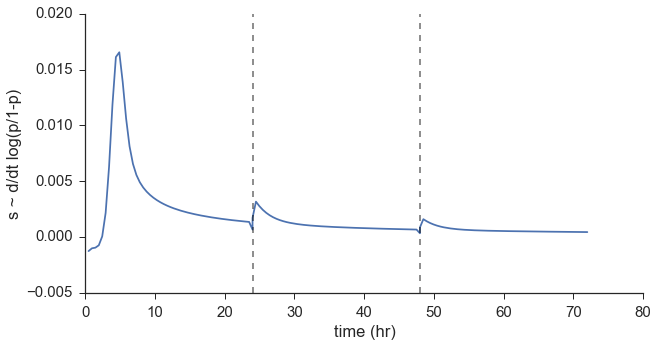

In [362]:
dlogppdt = np.gradient(logpp, t)

fig, ax = subplots(1,1,figsize=(10,5))
ax.plot(t,dlogppdt)
ax.set_xlabel('time (hr)')
ax.set_ylabel('s ~ d/dt log(p/1-p)')
sns.despine();
[axvline(x=x, color='k', ls='--', alpha=0.5) for x in np.arange(0, t.max(), cycle_len)];

In [370]:
def haldane(t,p0,s):
    return p0/(p0 + (1 - p0)*(1-s)**t)
haldane_model = Model(haldane)

{'p0': 0.50842377885167467, 's': 0.067025384510265698}


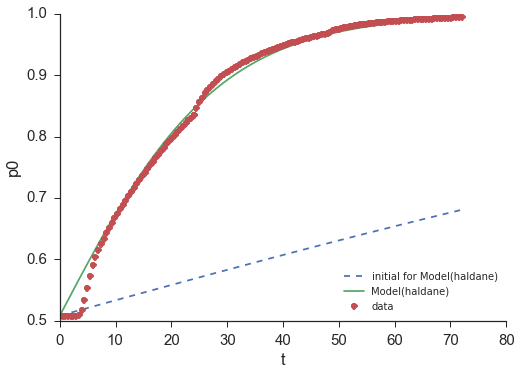

In [381]:
params = haldane_model.make_params(p0=p[0,0], s=0.01)
params['p0'].set(min=1e-10, max=1-1e-10, vary=False)
params['s'].set(min=1e-10, max=0.5)
model_fit = haldane_model.fit(p[:,0], t=t, params=params)
model_fit.plot_fit()
legend(loc='lower right', fontsize=10)
ylabel('p0')
sns.despine()
print model_fit.best_values